In [307]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical


In [258]:

history_lst = []

In [314]:
x_train = np.load('train_data.npy')
y_train = np.load('train_labels.npy')
x_test = np.load('test_data.npy')



In [315]:
# Reshape only if needed (check if flattened)
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    stratify=y_train)

In [318]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


# Create the CNN model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.27))

# Block 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

# Block 3
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# FC layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.55))
model.add(Dense(256, activation='relu'))  # <-- use relu here
model.add(Dense(10, activation='softmax'))

y_train_oh = to_categorical(y_train, num_classes=10)
y_val_oh = to_categorical(y_val, num_classes=10)

loss_fn = CategoricalCrossentropy(label_smoothing=0.1)


model.compile(optimizer=Adam(learning_rate=0.001),
              loss=loss_fn,
              metrics=['accuracy'])
# Train the model
#model.fit(x_train[:100], y_train[:100], epochs=30, batch_size=16, verbose=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train_oh, validation_data=(x_val, y_val_oh),
    epochs=80,
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)



history_lst.append(max(history.history['val_accuracy']))

Epoch 1/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2165 - loss: 2.5202 - val_accuracy: 0.1035 - val_loss: 6.7605 - learning_rate: 0.0010
Epoch 2/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3070 - loss: 1.9559 - val_accuracy: 0.3315 - val_loss: 1.9592 - learning_rate: 0.0010
Epoch 3/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3492 - loss: 1.8768 - val_accuracy: 0.3880 - val_loss: 1.9312 - learning_rate: 0.0010
Epoch 4/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4054 - loss: 1.7672 - val_accuracy: 0.4400 - val_loss: 1.7308 - learning_rate: 0.0010
Epoch 5/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4581 - loss: 1.6774 - val_accuracy: 0.4505 - val_loss: 1.6820 - learning_rate: 0.0010
Epoch 6/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4873 - loss: 1.6200 - val_accuracy: 0.5070 - val_loss: 1.6136 - learning_rate: 0.0010
Epoch 7/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5184 - loss: 1.5543 

Maximum validation accuracy: 0.6990


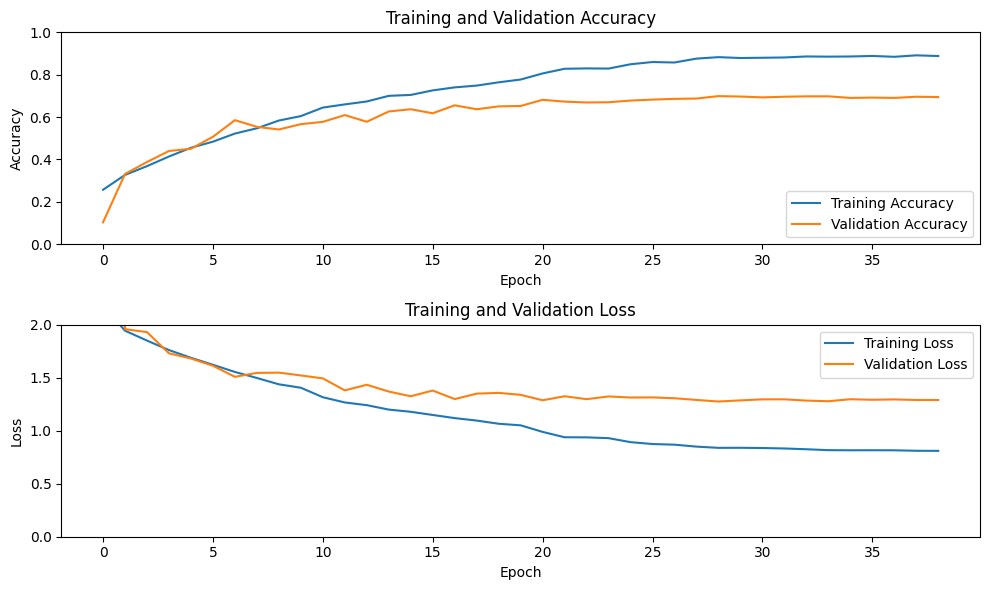

In [319]:
max_val_acc = max(history.history['val_accuracy'])
print(f"Maximum validation accuracy: {max_val_acc:.4f}")
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Set fixed y-axis limits (you can adjust based on your data range)
plt.ylim(0, 1)

# Plot training and validation loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Set fixed y-axis limits (you can adjust based on your data range)
plt.ylim(0, 2)

# Show the plot
plt.tight_layout()
plt.show()

In [320]:
print(history_lst)

[0.6614999771118164, 0.6679999828338623, 0.7315000295639038, 0.6485000252723694, 0.7210000157356262, 0.6915000081062317, 0.718500018119812, 0.7135000228881836, 0.6990000009536743]


In [321]:
predictions = np.argmax(model.predict(x_test), axis=1)
df = pd.DataFrame({'prediction': predictions})
df.to_csv('submission.csv', index=True, index_label='', sep=',')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')